In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from matplotlib import pyplot
from scipy import stats




In [2]:
def is_float(str):
    try:
        np.float64(str)
    except:
        return False
    else:
        return True

In [3]:
# Read the data

raw_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
# Some samples have NaN 'TotalCharges'. Those are only new costumers having 'tenure' == 0.
# We fix them to 'TotalCharges' = 0
raw_data.loc[(raw_data['tenure'] == 0) & (~raw_data['TotalCharges'].apply(is_float)), 'TotalCharges'] = 0
raw_data['TotalCharges'] = raw_data['TotalCharges']

print(f'Read {len(raw_data)} rows of data with {len(raw_data.columns)} columns')

Read 7043 rows of data with 21 columns


In [4]:
# Get a glimpse of the data
raw_data.info()
raw_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [5]:
# List the categorical features
categorical_columns = [
    'gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'PhoneService',
    'MultipleLines',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'Contract',
    'PaperlessBilling',
    'PaymentMethod',
]


In [6]:
# Get a better look at the categorical features

def count_distinct_values(df, column_name):
    return df[column_name].value_counts(dropna=False)

for column in categorical_columns:
    dict = count_distinct_values(raw_data, column)
    print(f'column {column} has {len(dict)} different categories')
    print(dict)
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')

column gender has 2 different categories
Male      3555
Female    3488
Name: gender, dtype: int64
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
column SeniorCitizen has 2 different categories
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
column Partner has 2 different categories
No     3641
Yes    3402
Name: Partner, dtype: int64
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
column Dependents has 2 different categories
No     4933
Yes    2110
Name: Dependents, dtype: int64
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
column PhoneService has 2 different categories
Yes    6361
No      682
Name: PhoneService, dtype: int64
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
column MultipleLines has 3 different categories
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
column InternetService has 3 different categories
Fiber optic    3096
DSL            2421
No             1526
Name: InternetServi

<AxesSubplot:xlabel='tenure'>

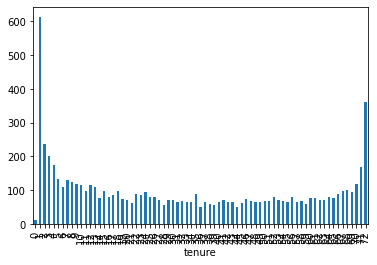

In [7]:
# Get a look at the label 'tenure' - for all samples

raw_data.groupby('tenure')['tenure'].count().plot.bar()


<AxesSubplot:xlabel='tenure'>

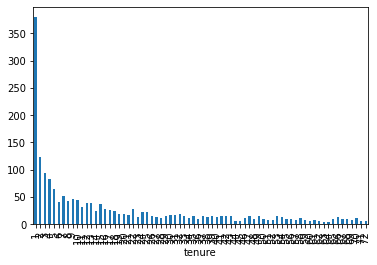

In [8]:
# Get a look at the label 'tenure' - for churners only

raw_data[raw_data['Churn'] == 'Yes'].groupby('tenure')['tenure'].count().plot.bar()

In [9]:
# Convert each categorical feature to a continuous feature by replacing each category with its respective average label

class BucketStatsFeatureTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, categorical_features, no_data_threshold, no_data_fallback):
        self.categorical_features = categorical_features
        self.no_data_threshold = no_data_threshold
        self.no_data_fallback = no_data_fallback
        print('BucketStatsFeatureTransformer:')
        print(f'categorical_features = {categorical_features}')
        print(f'no_data_threshold = {no_data_threshold}, no_data_fallback = {no_data_fallback}')

    def fit(self, x, y):
        if self.no_data_fallback is None:
            self.no_data_fallback = y.mean()
        self.stats_dict = {}
        for column_name in self.categorical_features:
            self.stats_dict[column_name] = self.get_one_column_stats(x, column_name, y)
        return self

    def get_one_column_stats(self, x, column_name, y):
        df = pd.concat([x[column_name], y], axis=1)
        df.columns = [column_name, 'label']
        stats = df.groupby([column_name])['label'].agg(['mean', 'count'])
        stats = stats[stats['count'] >= self.no_data_threshold]
        stats.drop('count', axis=1, inplace=True)

        print(f'Found {len(stats)} meaningful  buckets for categorical feature {column_name}')
        return stats
    
    def transform(self, x):
        for column_name in self.categorical_features:
            x = self.transform_one_column(x, column_name)
        return x

    def transform_one_column(self, x, column_name):
        stats_df = self.stats_dict[column_name]
        df = pd.merge(x, stats_df, how='left', left_on=column_name, right_index=True)
        df.loc[df['mean'].isna(), 'mean'] = self.no_data_fallback
        df.drop(column_name, axis=1, inplace=True)
        df.rename(columns={'mean': column_name}, inplace=True)
        return df


In [10]:
# Filter the data and keep churners only
churn_only_regression_data = raw_data[raw_data['Churn'] == 'Yes'].copy()

# x,y split - 'tenure' is our label
regression_label = churn_only_regression_data['tenure'].astype('float64')

# Drop undesired columns including 'Churn' and 'tenure'
# but also 'customerID' which is meaningles and 'TotalCharges' which is highly correlated with 'tenure'
regression_features = churn_only_regression_data.drop(['customerID', 'Churn', 'tenure', 'TotalCharges'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    regression_features, regression_label, test_size=0.2, random_state=333)

In [11]:
def print_regression_scores(title, predicted, actual):
    diff = predicted - actual
    mae = abs(diff).mean()
    rmse = (diff * diff).mean()**0.5
    pearson_correlation = stats.pearsonr(predicted, actual)[0]
    pearson_correlation = stats.pearsonr(predicted, actual)[0]
    print(f'{title}: {mae:.6f}, {rmse:.6f}, {pearson_correlation:.6f}')


BucketStatsFeatureTransformer:
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
no_data_threshold = 100, no_data_fallback = None
Starting XGBRegressor.fit()
Found 2 meaningful  buckets for categorical feature gender
Found 2 meaningful  buckets for categorical feature SeniorCitizen
Found 2 meaningful  buckets for categorical feature Partner
Found 2 meaningful  buckets for categorical feature Dependents
Found 2 meaningful  buckets for categorical feature PhoneService
Found 3 meaningful  buckets for categorical feature MultipleLines
Found 2 meaningful  buckets for categorical feature InternetService
Found 2 meaningful  buckets for categorical feature OnlineSecurity
Found 2 meaningful  buckets for categorical feature OnlineBackup
Found 2 meaningful  buckets for c

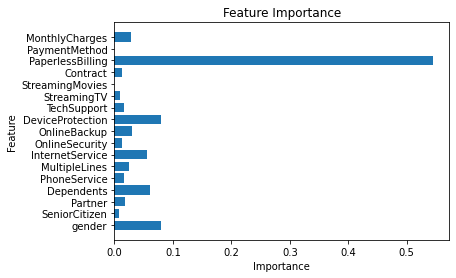

In [12]:
# XGBRegressor
xgb_regressor = xgb.XGBRegressor(learning_rate=0.1, max_depth=3, min_child_weight=10, reg_alpha=0.0, reg_lambda=10.0, n_estimators=50)
pipe = Pipeline([
    ('bucket_stats', BucketStatsFeatureTransformer(categorical_columns, no_data_threshold=100, no_data_fallback=None)),
    ('regressor', xgb_regressor)
])
print('Starting XGBRegressor.fit()')
model = pipe.fit(x_train, y_train)

print(f'train score = {model.score(x_train, y_train)}')
print(f'test score = {model.score(x_test, y_test)}')

feature_importances = xgb_regressor.feature_importances_
pyplot.barh(x_train.columns, feature_importances)
pyplot.title('Feature Importance')
pyplot.ylabel('Feature')
pyplot.xlabel('Importance')
pyplot.show()


In [13]:
print('calculating scores (MAE, RMSE, Pearson Correlation)')
trivial_baseline = np.ones(y_test.shape) * y_train.mean()
print_regression_scores('trivial baseline', trivial_baseline, y_test)

predictions = model.predict(x_test)
print_regression_scores('xgb', predictions, y_test)


calculating scores (MAE, RMSE, Pearson Correlation)
trivial baseline: 15.869379, 19.478834, nan
xgb: 9.273714, 12.703180, 0.760846


C:\Users\97250\AppData\Roaming\Python\Python38\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
